In [1]:
from Utils import *
import Network as models
import os
import pandas as pd
import torch
from tqdm import tqdm

In [2]:
model = models.create_model(None, "Global_Regressor")

Get Global_Regressor


In [3]:
model

Global_Regressor(
  (encoder): VGG(
    (features): Sequential(
      (stage1): Sequential(
        (unit1): ConvBlock(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (unit2): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU(inplace=True)
        )
        (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (stage2): Sequential(
        (unit1): ConvBlock(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activ): ReLU

In [4]:
import pandas as pd

In [47]:
train_df = pd.read_csv('../../MWR/datalist/utk/UTK_train_coral.csv')

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13146 entries, 0 to 13145
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13146 non-null  int64 
 1   filename    13146 non-null  object
 2   age         13146 non-null  int64 
 3   database    13146 non-null  object
dtypes: int64(2), object(2)
memory usage: 410.9+ KB


In [49]:
train_df = train_df.drop(["Unnamed: 0", "database"], axis=1)

<AxesSubplot:>

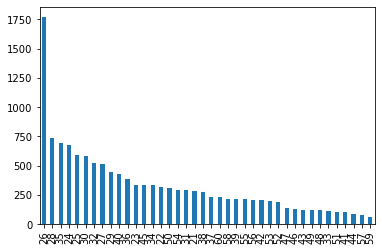

In [50]:
train_df['age'].value_counts().plot(kind='bar')

In [51]:
np.array(sorted(train_df['age'].unique())) # 21 -> 60

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60], dtype=int64)

In [151]:
tau = 6
min_age = 21
max_age = 60
sample_per_age = 5

for lb in tqdm(range(min_age, max_age + 1)):
    ub = min(max_age, lb + tau)
    
    min_age_candidate = train_df[train_df['age'] == lb]
    max_age_candidate = train_df[train_df['age'] == ub]
    
    for age in range(lb, ub + 1):
        curr_age_candidate = train_df[train_df['age'] == age]
        if (age == min_age):
            lb_df = min_age_candidate.sample(n=sample_per_age*2)
            curr_df = lb_df.iloc[:int(len(lb_df)/2), :]
            lb_df = lb_df.iloc[int(len(lb_df)/2):, :]
            ub_df = max_age_candidate.sample(n=sample_per_age)
            all_df = lb_df.merge(curr_df, how='cross')
            all_df = all_df.merge(ub_df, how='cross')
        elif (age == max_age):
            lb_df = min_age_candidate.sample(n=sample_per_age)
            ub_df = max_age_candidate.sample(n=sample_per_age*2)
            curr_df = ub_df.iloc[:int(len(ub_df)/2), :]
            ub_df = ub_df.iloc[int(len(ub_df)/2):, :]

            temp_all_df = lb_df.merge(curr_df, how='cross')
            temp_all_df = temp_all_df.merge(ub_df, how='cross')

            all_df = pd.concat([all_df, temp_all_df], ignore_index=True)
        else:
            lb_df = min_age_candidate.sample(n=sample_per_age)
            curr_df = curr_age_candidate.sample(n=sample_per_age)
            ub_df = max_age_candidate.sample(n=sample_per_age)

            temp_all_df = lb_df.merge(curr_df, how='cross')
            temp_all_df = temp_all_df.merge(ub_df, how='cross')

            all_df = pd.concat([all_df, temp_all_df], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.04it/s]


In [153]:
all_df.columns = ['filename_lb', 'age_lb', 'filename_curr', 'age_curr', 'filename_ub', 'age_ub']

In [162]:
all_df['p_rank'] = (all_df['age_curr'] - (all_df['age_ub'] + all_df['age_lb'])/2)/((all_df['age_ub'] - all_df['age_lb'])/2)

In [9]:
all_df['filename_lb'] = all_df['filename_lb'] + ".chip.jpg"
all_df['filename_curr'] = all_df['filename_curr'] + ".chip.jpg"
all_df['filename_ub'] = all_df['filename_ub'] + ".chip.jpg"

In [ ]:
all_df.to_csv('pregressor_train_data.csv', index=False)

In [5]:
all_df = pd.read_csv('pregressor_train_data.csv')

<AxesSubplot:>

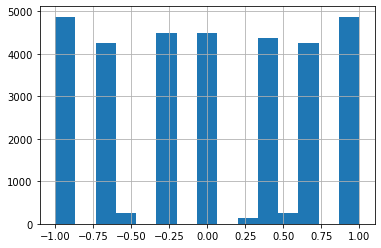

In [6]:
all_df['p_rank'].hist(bins=15)

In [7]:
all_df_ = all_df.head(5)

In [8]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from DataLoader import *
import os
import torch.nn as nn

In [9]:
Images_train = ImageLoaderForTrain(None, all_df_)

In [10]:
dataloader_Images_train = DataLoader(Images_train, batch_size=11, shuffle=False, num_workers=4)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
criteria = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1

for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader_Images_train)):
        X, y = data
        
        # convert data to float
        # https://stackoverflow.com/questions/67456368/pytorch-getting-runtimeerror-found-dtype-double-but-expected-float
        X = X.float().to(device)
        y = y.float().to(device)
        optimizer.zero_grad()
        
        output = torch.squeeze(model('train', x_1_1=X[:, 0, :, :, :], x_1_2=X[:, 1, :, :, :], x_2=X[:, 2, :, :, :]))
        loss = criteria(output, y)
        # output = output.cpu().detach().numpy()
        
        training_loss = loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i % 2 == 0:
            print(f"Training loss: {training_loss}")
    
    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.99s/it]

Training loss: 1.0227367877960205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.37s/it]


In [31]:
output

tensor([-0.0899, -0.0452, -0.0217, -0.0115, -0.1346],
       grad_fn=<SqueezeBackward0>)

In [32]:
y

tensor([-1., -1., -1., -1., -1.], dtype=torch.float64)